<a href="https://colab.research.google.com/github/Kavindu26/PDmate/blob/main/PDmate_Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Early Detect Parkinson’s disease by analysing hand drawings and hand writings

## Setup

In [1]:
#Get to know about the corrent version of pytorch
import torch
print(torch.__version__)

1.12.0+cu113


In [2]:
# Get to know about cuda device name
torch.cuda.get_device_name(0)

'Tesla T4'

In [3]:
# Tesla gpu configeration
!nvidia-smi

Thu Jul 21 15:35:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Install fastai latest library
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# mount the file to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Dataset

In [13]:
# Set the root and base path to get the iomage data
root_dir = "/content/drive/MyDrive/PDmate_Final_Implementation"
base_dir = root_dir + '/Dataset'

In [14]:
# Automatically reload all changed code of IPython
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
# Import useful packages
from fastai.vision import *
from fastai.metrics import *
from fastai.vision.all import *
from fastai.data.core import DataLoaders
import matplotlib.pyplot as plt

In [16]:
import numpy as np # linear algebra
np.random.seed(7)

### Looking at the Data and Data Augmentation using DataLoaders

In [17]:
# Image data augmentation to increse the dataset image count
aug_tfms = aug_transforms(mult=1.5, 
                          do_flip=True, 
                          flip_vert=True, 
                          max_rotate=180.0, 
                          max_lighting=0.3, 
                          max_warp=0.2, 
                          p_affine=0.75, 
                          p_lighting=0.65, 
                          xtra_tfms=None,  
                          mode='bilinear', 
                          pad_mode='reflection', 
                          batch=False, 
)

In [18]:
# Loading and augment images( size 256 )
data = ImageDataLoaders.from_folder(base_dir, valid='test', bs=8, item_tfms=Resize(256), batch_tfms=[*aug_tfms, Normalize.from_stats(*imagenet_stats)])

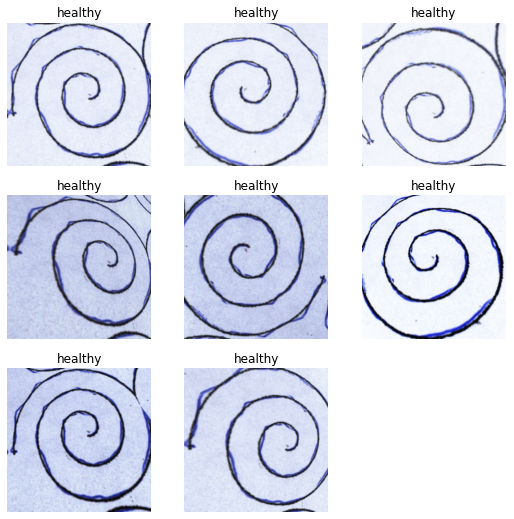

In [ ]:
# Show the input dataset
data.show_batch(max_n=12, nrows=3, unique=True)

In [19]:
# Show the image label
data.vocab

['healthy', 'parkinson']

In [20]:
# Print the train and test image data count
print(f"""Training Dataset Length: {len(data.train_ds)}\n
Validation Dataset Length: {len(data.valid_ds)}""")

Training Dataset Length: 1172

Validation Dataset Length: 296


### Training: resnet152

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://downlo

  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.855259,0.667470,0.773649,04:21
1,0.899364,0.781807,0.793919,00:38
2,0.761455,0.477270,0.824324,00:36
3,0.680049,0.403172,0.834459,00:36
4,0.624420,0.439521,0.844595,00:36
5,0.505816,0.525255,0.820946,00:38
6,0.435947,0.382624,0.861486,00:36
7,0.376289,0.922306,0.652027,00:37
8,0.422674,0.332298,0.871622,00:37
9,0.393737,0.500130,0.712838,00:37


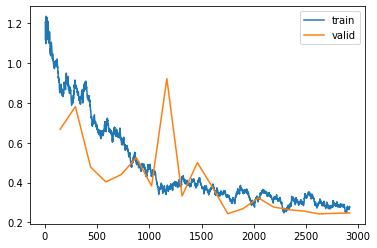

In [21]:
# Training the model using resnet152 classifier algorithem
learn = cnn_learner(data, models.resnet152, metrics=accuracy, opt_func=Adam).to_fp32()
learn.fit_one_cycle(20);
learn.recorder.plot_loss()

SuggestedLRs(valley=0.001737800776027143)

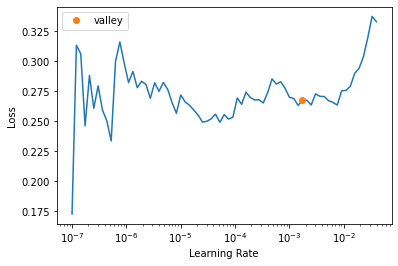

In [22]:
# Plots lr vs loss relationship using Learning rate finder
learn.lr_find()

### Unfreezing, fine-tuning, and learning rates

In [28]:
# unferrze the previous model and train the last layer
learn.unfreeze()
learn.fit_one_cycle(20, lr_max=1e-04)

epoch,train_loss,valid_loss,accuracy,time
0,0.478725,0.478257,0.780405,00:50
1,0.529844,0.463330,0.783784,00:49
2,0.494339,0.475262,0.797297,00:49
3,0.469935,0.546786,0.743243,00:50
4,0.507149,0.530293,0.763514,00:49
5,0.485632,0.478985,0.790541,00:51
6,0.440968,0.499700,0.777027,00:49
7,0.439424,0.480665,0.783784,00:49
8,0.436468,0.444079,0.804054,00:50
9,0.467321,0.450323,0.793919,00:49


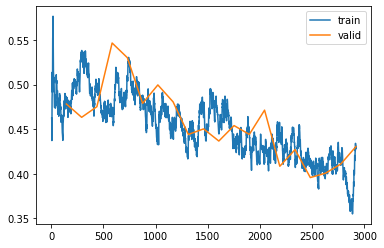

In [29]:
learn.recorder.plot_loss()

In [30]:
# Save the model
learn.save('stage-1')

Path('/content/drive/MyDrive/PDmate_Final_Implementation/Dataset/models/stage-1.pth')

In [31]:
# Interpret the model's performance
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

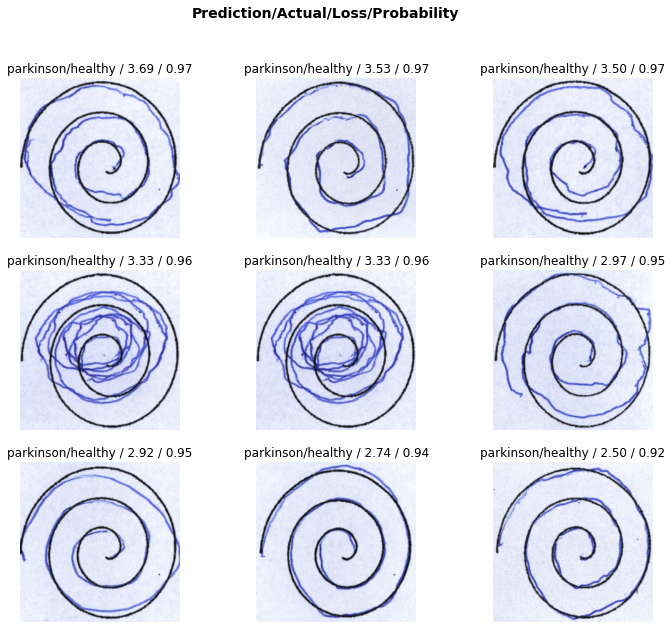

In [32]:
# See the top losses
interp.plot_top_losses(9, figsize=(12,10))

In [33]:
# Train the midel again using the size of 512px image with the help of preivous model
data = ImageDataLoaders.from_folder(base_dir, valid='test', bs=8, item_tfms=Resize(512), batch_tfms=[*aug_tfms, Normalize.from_stats(*imagenet_stats)])
learn = cnn_learner(data, models.resnet152, metrics=accuracy, opt_func=Adam).to_fp32()
learn.load('stage-1') # Loading the weights of the previous model
learn.fit(20)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.439218,0.481960,0.793919,01:52
1,0.497571,0.503036,0.763514,01:52
2,0.492079,0.453665,0.787162,01:52
3,0.440909,0.448277,0.770270,01:52
4,0.466663,0.474354,0.750000,01:52
5,0.444889,0.491129,0.773649,01:51
6,0.450026,0.472769,0.787162,01:51
7,0.464308,0.462020,0.773649,01:51
8,0.473845,0.473655,0.777027,01:51
9,0.453676,0.454633,0.793919,01:51


In [34]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, opt_func=Adam).to_fp32()
learn.fit_one_cycle(20)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.789650,0.397391,0.858108,01:50
1,0.772208,0.817389,0.844595,01:51
2,0.703869,0.661872,0.804054,01:52
3,0.616453,0.612905,0.807432,01:53
4,0.574330,0.507408,0.861486,01:53
5,0.467978,0.451064,0.851351,01:53
6,0.423755,0.407590,0.831081,01:53
7,0.445185,0.462493,0.817568,01:53
8,0.401543,0.363098,0.851351,01:53
9,0.386150,0.322705,0.898649,01:52


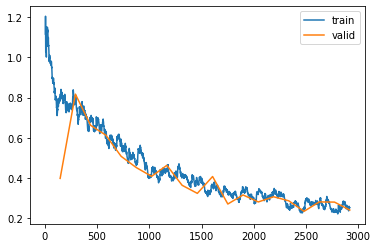

In [35]:
learn.recorder.plot_loss()

SuggestedLRs(valley=3.0199516913853586e-05)

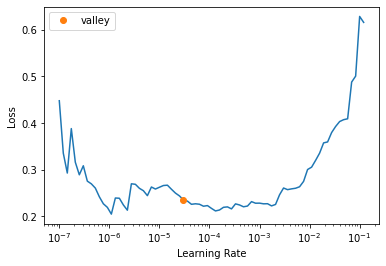

In [36]:
learn.lr_find()

In [37]:
learn.unfreeze()
learn.fit_one_cycle(20, lr_max=slice(1e-05, 1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.232366,0.244599,0.912162,02:28
1,0.247105,0.267395,0.908784,02:30
2,0.287342,0.275231,0.891892,02:31
3,0.280623,0.241558,0.905405,02:32
4,0.322790,0.301715,0.868243,02:31
5,0.302469,0.349434,0.854730,02:31
6,0.311937,0.280287,0.891892,02:31
7,0.309000,0.304033,0.871622,02:31
8,0.309341,0.232727,0.898649,02:31
9,0.311762,0.258259,0.905405,02:31


In [38]:
learn.save('stage-2')

Path('/content/drive/MyDrive/PDmate_Final_Implementation/Dataset/models/stage-2.pth')

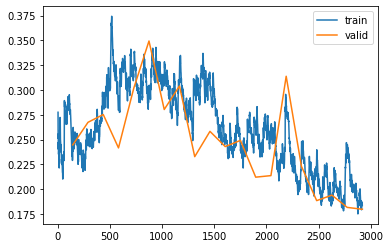

In [39]:
learn.recorder.plot_loss()

SuggestedLRs(valley=3.311311274956097e-06)

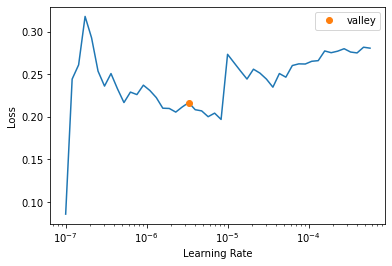

In [41]:
learn.lr_find()

In [42]:
learn.fit_one_cycle(20, lr_max=slice(1e-06, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.202749,0.191445,0.922297,02:27
1,0.186522,0.175408,0.929054,02:30
2,0.242810,0.186420,0.929054,02:31
3,0.199589,0.192784,0.925676,02:31
4,0.203295,0.207952,0.922297,02:31
5,0.184169,0.203540,0.918919,02:32
6,0.189672,0.183791,0.929054,02:31
7,0.201060,0.187160,0.918919,02:31
8,0.175249,0.180755,0.935811,02:31
9,0.192548,0.175363,0.929054,02:31


### Deploying the Model

In [43]:
# Save the final model
learn.save('stage-2-rn152-512px')

Path('/content/drive/MyDrive/PDmate_Final_Implementation/Dataset/models/stage-2-rn152-512px.pth')

In [44]:
# Save the model as a pickle file
learn.export('predict-parkinson-disease.pkl')

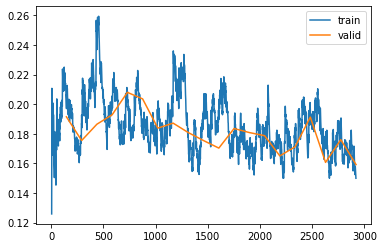

In [45]:
learn.recorder.plot_loss()

### Result

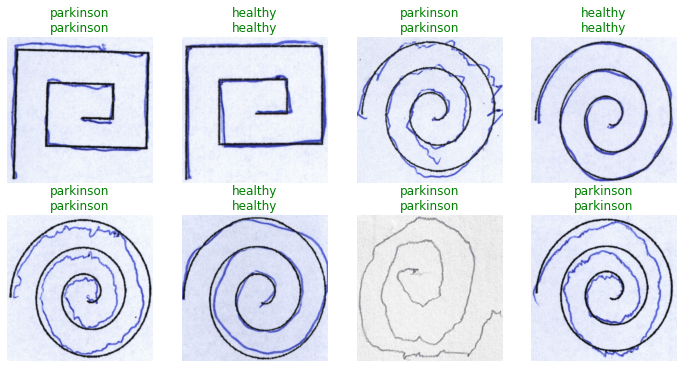

In [46]:
# Show the result of prediction using the test data
learn.show_results()

### Inference

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

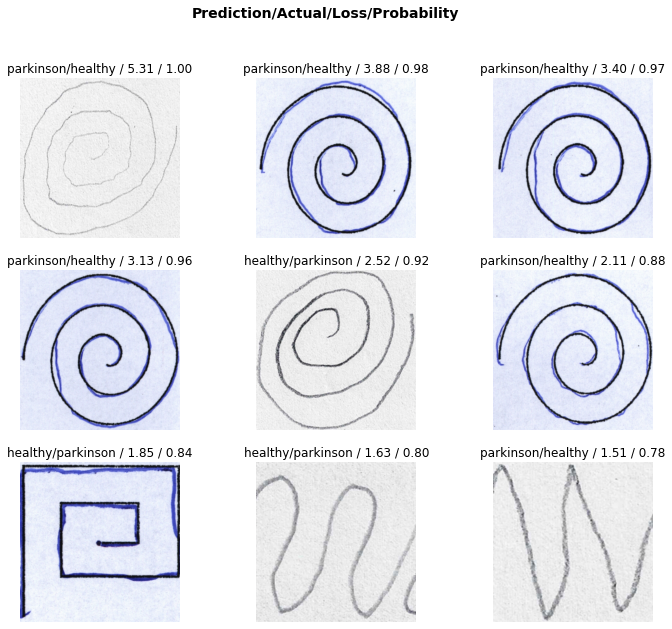

In [48]:
# See the top losses
interp.plot_top_losses(9, figsize=(12,10))

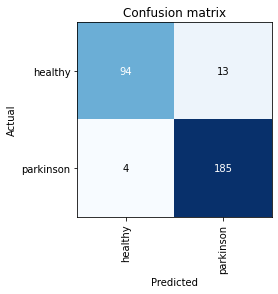

In [49]:
# Visualise the confusion metrix
interp.plot_confusion_matrix()
plt.savefig("confusion_matrix.png", bbox_inches='tight', padding=0)

In [50]:
interp.print_classification_report()

              precision    recall  f1-score   support

     healthy       0.96      0.88      0.92       107
   parkinson       0.93      0.98      0.96       189

    accuracy                           0.94       296
   macro avg       0.95      0.93      0.94       296
weighted avg       0.94      0.94      0.94       296



In [51]:
interp.most_confused(min_val=2)

[('healthy', 'parkinson', 13), ('parkinson', 'healthy', 4)]